In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

from src.model import Lightcurve
from src.model.enums import EnumSortOptions
from src.utils import AsteroidLoader, LightcurveBinner, LightcurvePlotter
from src.utils.enums import BinningMethod

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
asteroid_loader = AsteroidLoader()
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()

In [3]:
C_G_S = "\033[1;32m"
C_Y_S = "\033[1;33m"
C_E = "\033[0m"


### Nice asteroids:
 - Eunomia
 - Interamnia
 - Eros
 - Ceres

In [4]:
asteroid_name = "Kalliope"


In [5]:
asteroid = asteroid_loader.load_asteroid(asteroid_name)
asteroid

Asteroid(id=22, name=Kalliope, period=4.1482015, lightcurves=155)

In [6]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.PERIOD)

Lightcurve(id=820, period=9.64399h points_count=212, first_JD=2443108.271001, last_JD=2443108.672834)

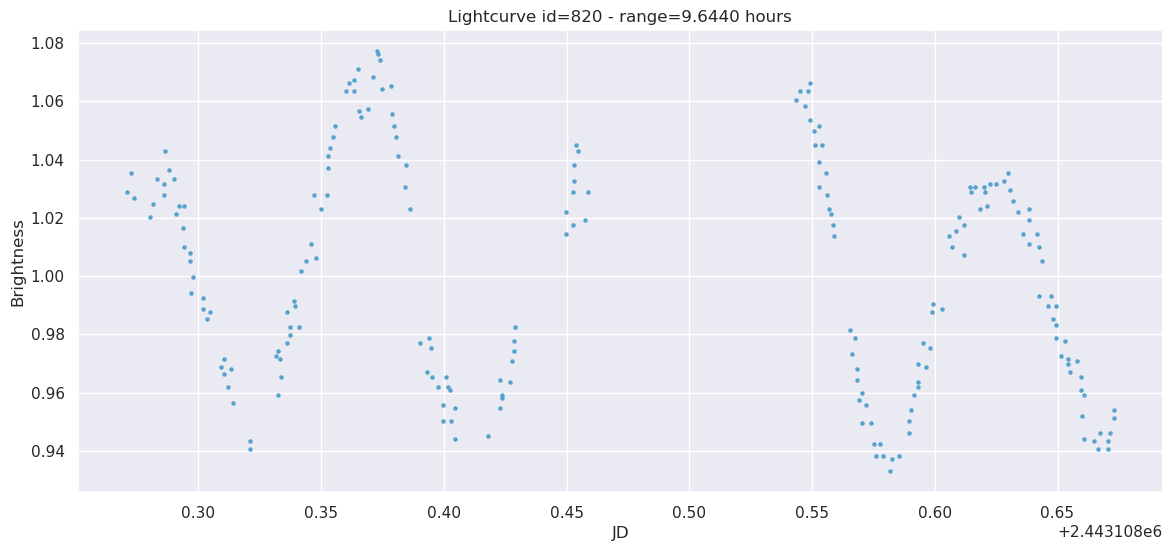

In [7]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.PERIOD).plot()

In [8]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.POINTS)

Lightcurve(id=21112, period=6.82130h points_count=1387, first_JD=2458227.328095, last_JD=2458227.612316)

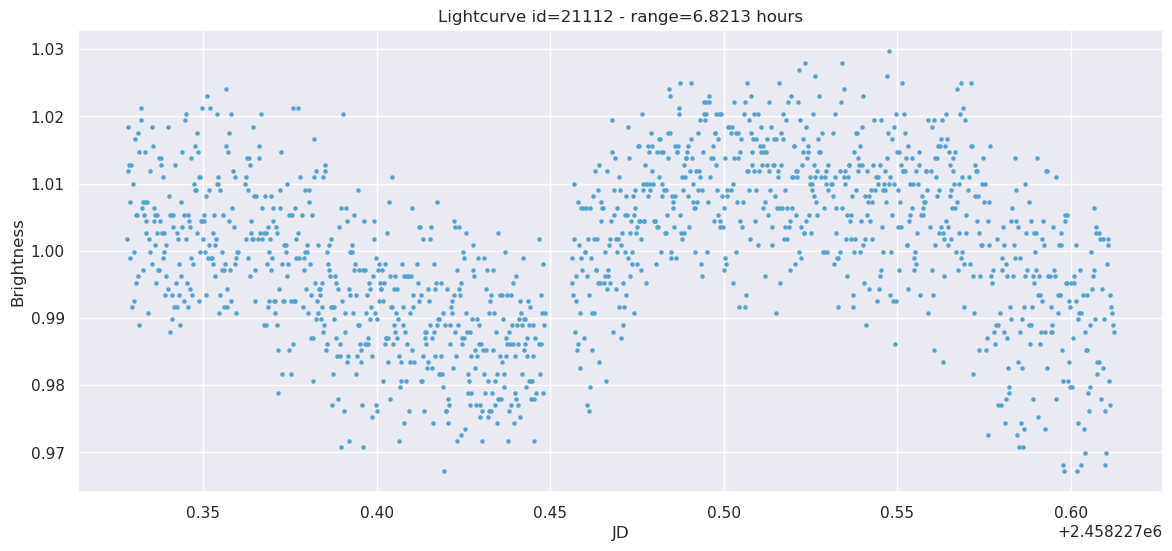

In [9]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.POINTS).plot()

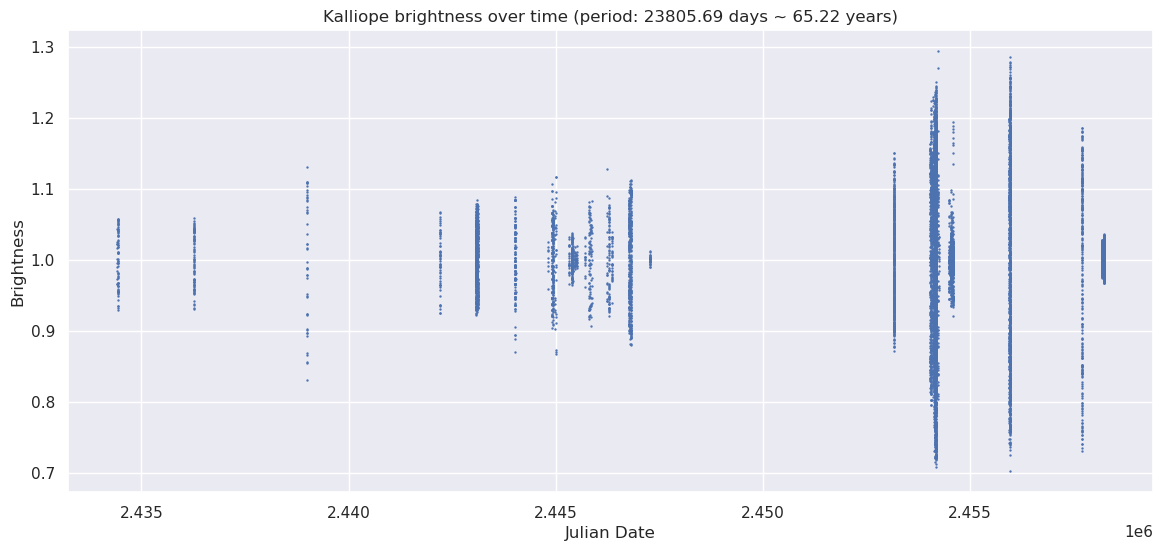

In [10]:
brightness = []
times = []
for lc in asteroid.lightcurves:
    for point in lc.points:
        brightness.append(point.brightness)
        times.append(point.JD)

period = times[-1] - times[0]

plt.scatter(times, brightness, s=0.5)
plt.xlabel("Julian Date")
plt.ylabel("Brightness")
plt.title(f"{asteroid.name} brightness over time (period: {period:.2f} days ~ {period / 365:.2f} years)")
plt.show()


In [11]:
MAX_DIFF_THRESHOLD = 45  # days
bins = lightcurve_binner.bin_lightcurves_from_asteroid(
    asteroid, MAX_DIFF_THRESHOLD, binning_method=BinningMethod.FIRST_TO_FIRST_DIFF
)

for ind, _bin in enumerate(bins):
    first_JD = _bin[0].first_JD
    last_JD = _bin[-1].last_JD
    print(f"{ind:2} - {C_Y_S}{len(_bin):2}{C_E} lcs from {first_JD:.2f} to {last_JD:.2f} {C_G_S}({last_JD - first_JD:5.2f} days){C_E}")

 0 -  2 lcs from 2434421.92 to 2434424.01 ( 2.09 days)
 1 -  1 lcs from 2436258.64 to 2436258.87 ( 0.23 days)
 2 -  1 lcs from 2439008.32 to 2439008.48 ( 0.16 days)
 3 -  1 lcs from 2442211.27 to 2442211.44 ( 0.18 days)
 4 -  7 lcs from 2443069.34 to 2443110.44 (41.11 days)
 5 -  1 lcs from 2443121.22 to 2443121.38 ( 0.16 days)
 6 -  6 lcs from 2444016.36 to 2444051.22 (34.86 days)
 7 -  1 lcs from 2444822.89 to 2444822.97 ( 0.08 days)
 8 -  6 lcs from 2444912.27 to 2444940.17 (27.89 days)
 9 -  2 lcs from 2444978.68 to 2445017.91 (39.24 days)
10 -  2 lcs from 2445319.71 to 2445320.86 ( 1.15 days)
11 -  5 lcs from 2445383.81 to 2445422.79 (38.98 days)
12 -  4 lcs from 2445476.80 to 2445517.76 (40.96 days)
13 -  2 lcs from 2445714.82 to 2445715.86 ( 1.04 days)
14 -  4 lcs from 2445798.66 to 2445829.80 (31.14 days)
15 -  2 lcs from 2445861.81 to 2445886.82 (25.02 days)
16 -  2 lcs from 2446241.72 to 2446243.78 ( 2.06 days)
17 -  1 lcs from 2446294.57 to 2446294.85 ( 0.27 days)
18 -  4 lc

In [12]:
bins_sorted = sorted(bins, key=lambda x: len(x), reverse=True)
selected_bin = bins_sorted[0]


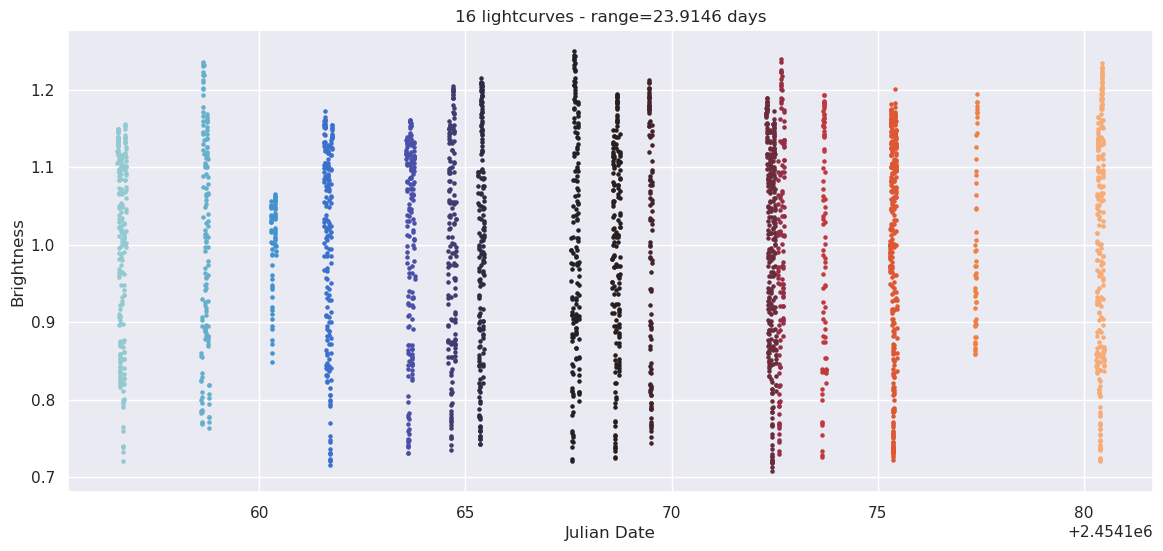

In [13]:
lightcurve_plotter.plot_lightcurves(selected_bin)

In [14]:
times = []
brightness = []
for lc in selected_bin:
    for points in lc.points:
        times.append(points.JD)
        brightness.append(points.brightness)


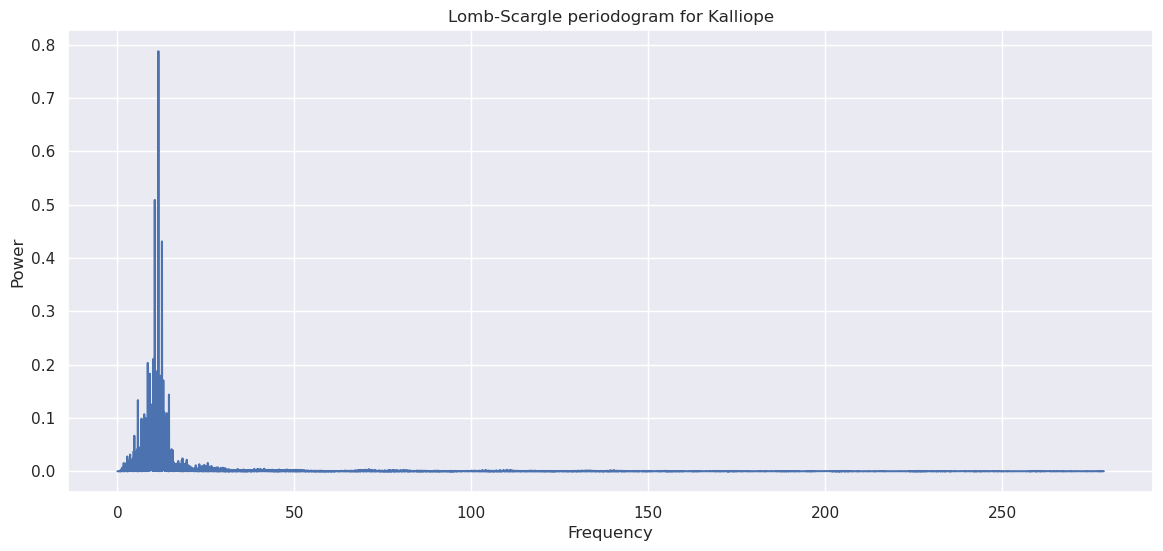

Best frequency: 11.570351332215427
Rotational period: 2.0742671774517856h


In [15]:
frequency, power = LombScargle(times, brightness).autopower()
fig = plt.plot(frequency, power)

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title(f"Lomb-Scargle periodogram for {asteroid_name}")
plt.show()

lomb_freq = frequency[np.argmax(power)]
lomb_period = 24 / lomb_freq

print(f"Best frequency: {lomb_freq}")
print(f"Rotational period: {lomb_period}h")

In [16]:
asteroid.period

4.1482015

In [17]:
lomb_period, lomb_period * 2

(2.0742671774517856, 4.148534354903571)

In [18]:
def get_phase(time: float, ref_time: float, period: float) -> float:
    return (time - ref_time) * 24 % period / period


In [19]:
def harmonic_model(phase, a0, a1, b1, a2, b2, offset):
    # a1, b1 are the coefficients for the fundamental harmonic (1st harmonic)
    # a2, b2 are the coefficients for the 2nd harmonic
    return (
        a0
        + a1 * np.cos(2 * np.pi * phase)
        + b1 * np.sin(2 * np.pi * phase)
        + a2 * np.cos(4 * np.pi * phase)
        + b2 * np.sin(4 * np.pi * phase)
        + offset
    )


def fourier_model(x, *params):
    n_harmonics = len(params) // 2
    a0 = params[0]
    result = a0
    for i in range(1, n_harmonics):
        a = params[2 * i - 1]
        b = params[2 * i]
        result += a * np.cos(2 * np.pi * i * x) + b * np.sin(2 * np.pi * i * x)
    return result

In [20]:
SELECTED_MODEL = fourier_model


def get_rrs_values(period_range):
    rss_values = []
    for curr_period in period_range:
        # print(f"Trying period: {curr_period:.6f}h")

        phases = []
        brightness = []
        ref_JD = None
        for ind, lc in enumerate(selected_bin):
            if ref_JD is None:
                ref_JD = lc.first_JD

            for point in lc.points:
                phase = get_phase(point.JD, ref_JD, curr_period)

                phases.append(phase)
                brightness.append(point.brightness)

        sorted_indices = np.argsort(phases)
        phases = np.array(phases)[sorted_indices]
        brightness = np.array(brightness)[sorted_indices]

        n_harmonics = 4  # Number of harmonics to include in the model
        initial_guess = [1.0] * (2 * n_harmonics + 1)  # Initial guess for the parameters
        popt, _ = curve_fit(SELECTED_MODEL, phases, brightness, p0=initial_guess, maxfev=10000)
        predicted_brightness = SELECTED_MODEL(phases, *popt)
        # popt, _ = curve_fit(harmonic_model, phases, brightness)

        # plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")
        # plt.plot(phases, predicted_brightness, label="Fit", color="orange")
        # plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
        # plt.xlabel("Phase")
        # plt.ylabel("Brightness")
        # plt.legend()
        # plt.show()

        residuals = brightness - predicted_brightness
        rss = np.sum(residuals**2)

        rss_values.append(rss)

    return rss_values

/tmp/ipykernel_61936/2845966903.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(SELECTED_MODEL, phases, brightness, p0=initial_guess, maxfev=10000)


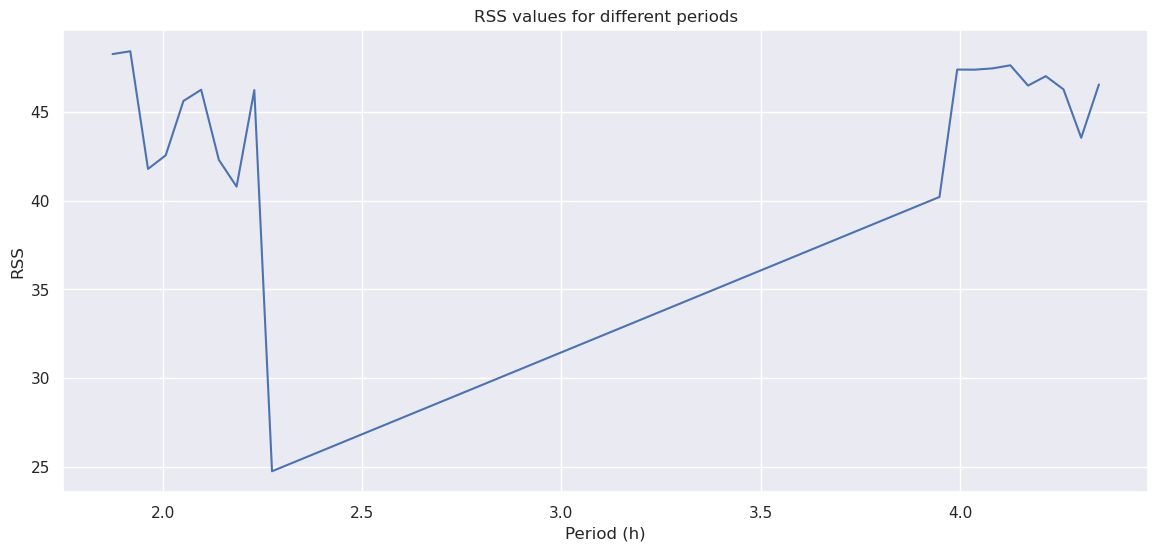

RSS values range: 24.740722 - 48.447503, threshold: 3.556017
Selected periods: [2.2742671774517857]

Best RSS value: 9.584362 found for period: 2.074267h
Compared to the known period: 4.148201h (diff: 2.073934h)


In [21]:
period_range = sorted(
    [lomb_period + i for i in np.linspace(-0.2, 0.2, 10)] + [2 * lomb_period + i for i in np.linspace(-0.2, 0.2, 10)]
)

rss_values = get_rrs_values(period_range)

plt.plot(period_range, rss_values)
plt.title("RSS values for different periods")
plt.xlabel("Period (h)")
plt.ylabel("RSS")
plt.show()

# Select the period with the lowest RSS as well as ones close to the lowest RSS
min_rss = np.min(rss_values)
max_rss = np.max(rss_values)
threshold = 0.15 * (max_rss - min_rss)
print(f"RSS values range: {min_rss:.6f} - {max_rss:.6f}, threshold: {threshold:.6f}")

selected_periods = []
for period, rss in zip(period_range, rss_values):
    if rss < min_rss + threshold:
        selected_periods.append(period)

print(f"Selected periods: {selected_periods}\n")

filtered_periods = []
filtered_rss = []
for period in selected_periods:
    period_range = np.linspace(period - 0.2, period + 0.2, 1000)
    rss_values = get_rrs_values(period_range)

    lowest_ind = np.argmin(rss_values)
    filtered_rss.append(rss_values[lowest_ind])
    filtered_periods.append(period_range[lowest_ind])

best_rss_ind = np.argmin(filtered_rss)

best_period = filtered_periods[best_rss_ind]
best_rss = filtered_rss[best_rss_ind]

print(f"Best RSS value: {best_rss:.6f} found for period: {best_period:.6f}h")
print(f"Compared to the known period: {asteroid.period:.6f}h (diff: {C_Y_S}{abs(asteroid.period - best_period):.6f}h{C_E})")

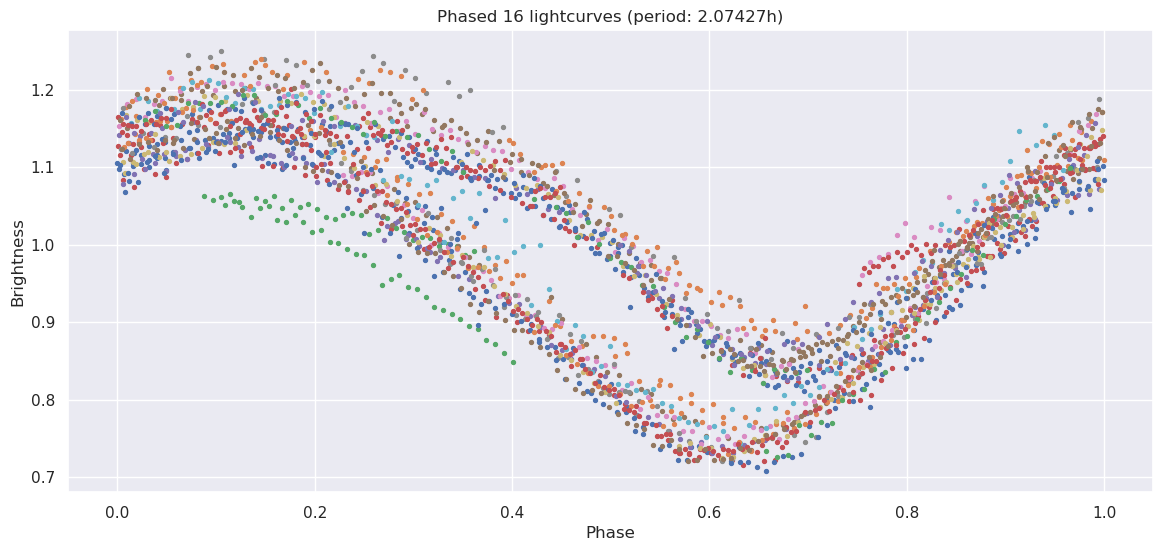

In [22]:
lightcurve_plotter.plot_phased_lightcurves(selected_bin, best_period)

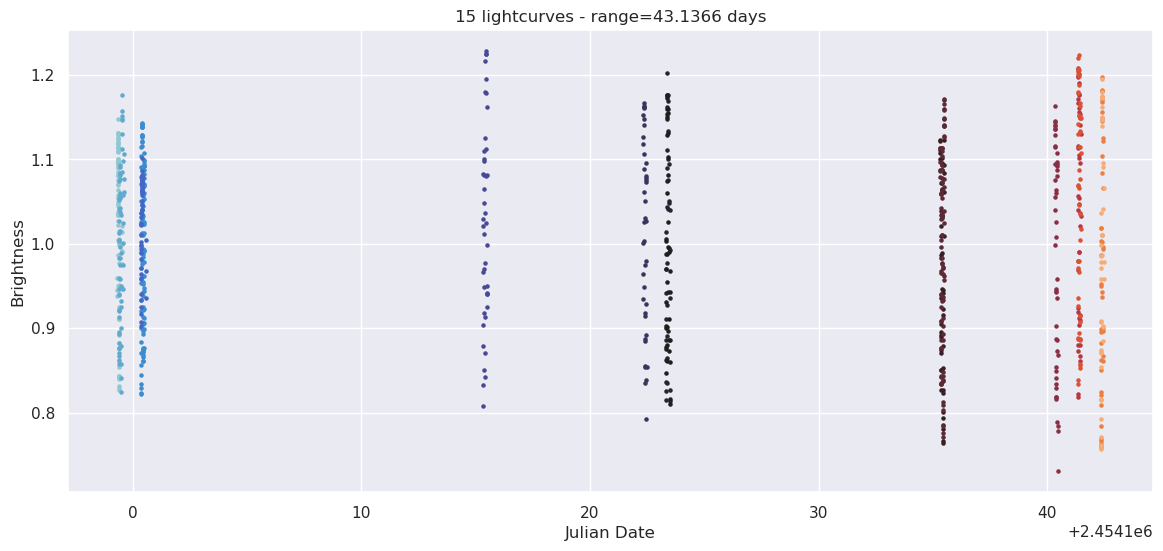

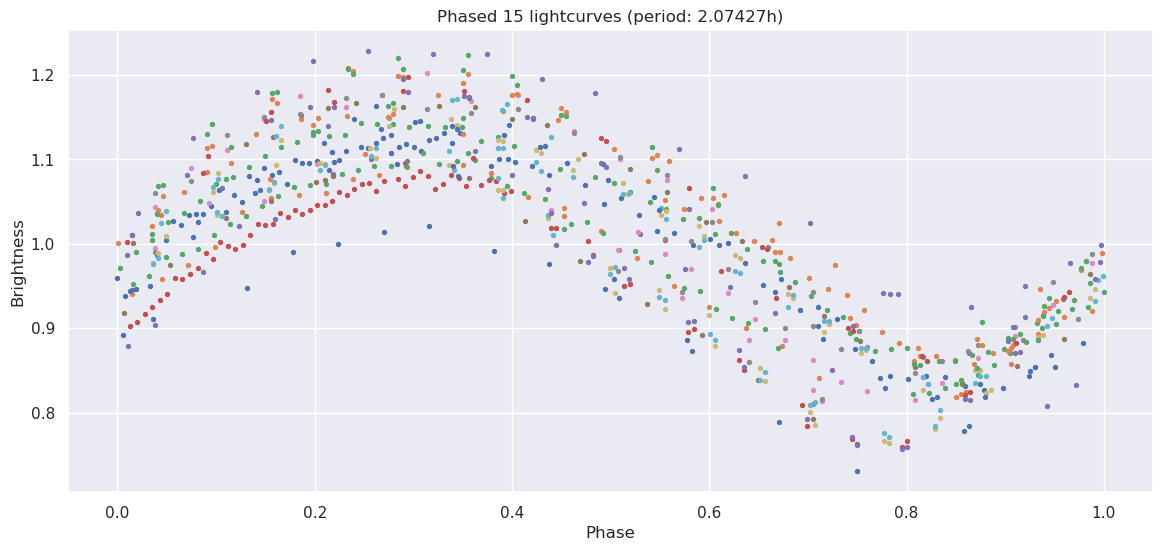

In [23]:
second_bin = bins_sorted[1]
lightcurve_plotter.plot_lightcurves(second_bin)
lightcurve_plotter.plot_phased_lightcurves(second_bin, best_period)



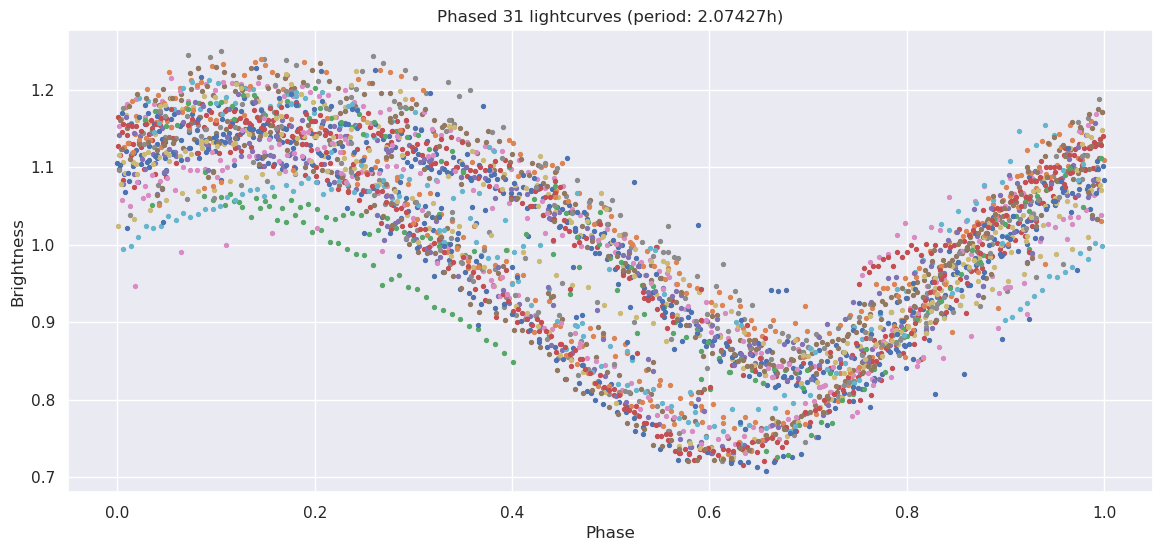

In [24]:
lightcurve_plotter.plot_phased_lightcurves(selected_bin + second_bin, best_period)